In [9]:
#!pip install -r "requirements.txt"

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [69]:
pd.options.display.max_columns = None

In [70]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [71]:
train.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,8259-DZLIZ,Female,0,Yes,Yes,64,Yes,Yes,DSL,No,Yes,No,No,No,No,One year,Yes,Bank transfer (automatic),53.85,3399.85
1,No,1764-VUUMT,Male,0,No,Yes,66,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.95,1269.1
2,Yes,1320-HTRDR,Female,0,No,No,3,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.50,220.6
3,No,1047-RNXZV,Male,0,No,No,43,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.55,876.15
4,No,0513-RBGPE,Male,0,Yes,Yes,37,Yes,Yes,DSL,Yes,No,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),62.80,2278.75


In [72]:
test.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,1985-MBRYP,Female,0,No,No,43,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.65,779.25
1,No,4878-BUNFV,Male,0,Yes,Yes,42,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.70,828.85
2,No,8728-SKJLR,Male,0,No,No,41,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,74.25,3089.1
3,Yes,7931-PXHFC,Male,0,No,No,38,Yes,No,DSL,No,No,Yes,Yes,No,Yes,One year,Yes,Mailed check,62.30,2354.8
4,Yes,2057-ZBLPD,Female,0,Yes,No,21,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,86.50,1808.7


# Analisi 

In [73]:
train.dtypes

Churn                object
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [74]:
train.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,4225.000000,4225.000000,4225.000000
mean,0.157870,32.382722,64.828036
std,0.364662,24.458995,30.118339
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.750000
50%,0.000000,29.000000,70.450000
75%,0.000000,55.000000,90.100000
max,1.000000,72.000000,118.600000


## Alcune considerazioni
- 2 feature numeriche già pronte all'uso (potrebbero esserne altre)
- La metà dei clienti ha un contratto da almeno 2 anni

## Valori mancanti

In [75]:
train.isnull().sum()

Churn               0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Pare non esserci valori nulli. La colonna TotalCharges però ha due problemi: deve essere convertita a float, contiene delle righe vuote.

In [76]:
len(train[train.TotalCharges == ''])

0

In [77]:
len(train[train.TotalCharges == ' '])

9

Ci sono delle righe di TotalCharges vuote. Come le sostituiamo? Idealmente TotalCharges rappresenta il totale delle fatture pagate. Quindi dovrebbe bastare moltiplicare la "tenure" (numero di mesi dell'abbonamento) per il costo mensile (considerando idealmente che il costo non aumenti nei mesi).

In [78]:
train[train.TotalCharges == ' '][['tenure', 'MonthlyCharges', 'TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
785,0,25.75,
992,0,19.85,
1444,0,61.90,
1501,0,20.25,
2474,0,25.35,
2493,0,56.05,
3619,0,19.70,
3710,0,52.55,
4024,0,80.85,


a confermare la nostra ipotesi è il fatto che la tenure in queste righe è 0. Probabilmente è stato inserito un valore vuoto invece che 0 nel caso di abbonamenti che non sono durati nemmeno un mese. Sostituiamo quindi i valori vuoti con il risultato della moltiplicazione detta sopra. In realtà, però, potremmo sostituire direttamente 0.

In [79]:
train.TotalCharges.replace(to_replace=" ", value=0, inplace=True)
test.TotalCharges.replace(to_replace=" ", value=0, inplace=True)

### CustomerID

In [80]:
train.customerID.nunique()

4225

CustomerID è un valore univoco per ogni cliente, perciò non influenza la probabilità di Churn

### Churn - Variabile target

In [81]:
train.Churn.value_counts()

No     3110
Yes    1115
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

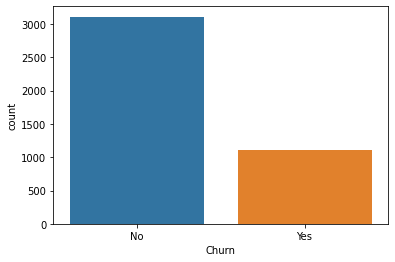

In [82]:
sns.countplot(x='Churn', data=train)

I clienti con Churn "NO" sono circa il triplo dei "Yes"

### Gender
Indica se il cliente è uomo o donna

In [83]:
train.gender.value_counts()

Male      2197
Female    2028
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

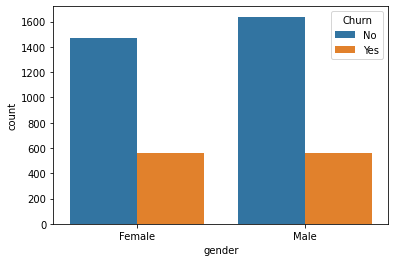

In [84]:
sns.countplot(x="gender", hue='Churn', data=train)

Il gender sembra non essere particolarmente influente sulla probabilità di Churn (è quasi equamente distributo al 50%)

### Partner

<AxesSubplot:xlabel='Partner', ylabel='count'>

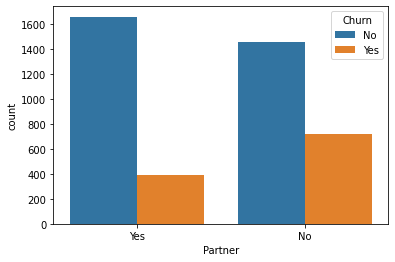

In [85]:
sns.countplot(x="Partner", hue='Churn', data=train)

Sembra sia più probabile che clienti senza partner abbiano un Churn Positivo rispetto a quelli che lo hanno

### Dependents

<AxesSubplot:xlabel='Dependents', ylabel='count'>

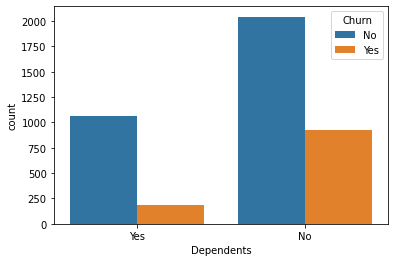

In [86]:
sns.countplot(x="Dependents", hue='Churn', data=train)

I clienti senza dipendenti hanno una probabilità più alta di avere Churn positivo

### MonthlyCharges
Rappresenta il costo mensile dell'abbonamento

<Figure size 576x432 with 0 Axes>

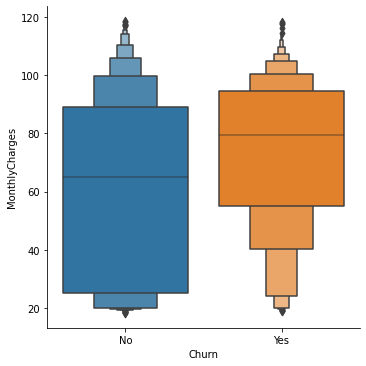

In [87]:
plt.figure(figsize=(8,6))
sns.catplot(x='Churn', y='MonthlyCharges', data=train, kind="boxen")

Dal grafico sembra che al diminuire dell'abbonamento mensile aumentino i Churn negativi. All'aumentare è difficile fare una stima, probabilmente c'è qualche altra feature che ne determina l'esito.

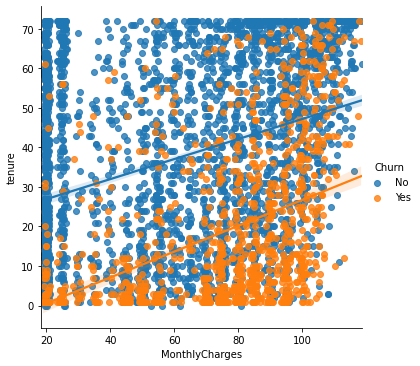

In [88]:
sns.lmplot(x='MonthlyCharges', y='tenure', hue='Churn', data=train)

Esiste una correlazione, sia nel caso di Churn positivo, che negativo, tra il costo mensile e la durata dell'abbonamento. 

### StreamingTV

<AxesSubplot:xlabel='StreamingTV', ylabel='count'>

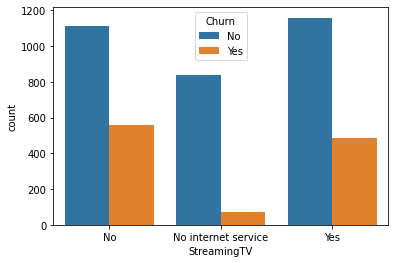

In [89]:
sns.countplot(x='StreamingTV', hue='Churn', data=train)

I clienti senza servizio internet è più probabile che abbiano Churn negativo. Mentre nel caso abbiamo o meno una StreamingTV è abbastanza irrilevante.

In [90]:
train.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,8259-DZLIZ,Female,0,Yes,Yes,64,Yes,Yes,DSL,No,Yes,No,No,No,No,One year,Yes,Bank transfer (automatic),53.85,3399.85
1,No,1764-VUUMT,Male,0,No,Yes,66,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.95,1269.1
2,Yes,1320-HTRDR,Female,0,No,No,3,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.50,220.6
3,No,1047-RNXZV,Male,0,No,No,43,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.55,876.15
4,No,0513-RBGPE,Male,0,Yes,Yes,37,Yes,Yes,DSL,Yes,No,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),62.80,2278.75


<AxesSubplot:xlabel='InternetService', ylabel='count'>

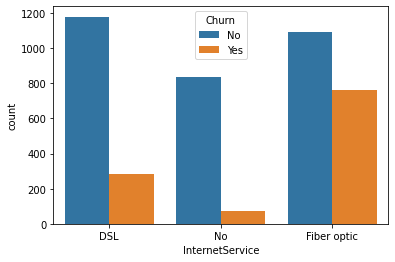

In [91]:
sns.countplot(x='InternetService', hue='Churn', data=train)

Chi ha un Internet Service di tipo DSL, oppure chi non lo ha proprio, è più probabile che abbia un Churn negativo. Potrebbe avere senso introdurre una feature del tipo "InternetService" di tipo Yes/No

# Feature Engineering

In [92]:
train.dtypes

Churn                object
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Abbiamo 3 feature numeriche (tenure, MonthlyCharges e totalCharges),  feature binarie (di tipo Yes/No) e le altre categoriche con 3 valori.
Ci resta da transformare le binarie in numeriche (da Yes/No a 1 e 0) e convertire le categoriche a 3 valori.

## Eliminazione Feature in base all'analisi

In [93]:
try: 
    train = train.drop(columns=['customerID'])
    test = test.drop(columns=['customerID'])
except:
    print("CustomerID non presente")

In [94]:
try: 
    train = train.drop(columns=['gender'])
    test = test.drop(columns=['gender'])
except:
    print("Gender non presente")

In [95]:
try:
    train.drop(columns='StreamingTV', inplace=True)
    test.drop(columns='StreamingTV', inplace=True)
except:
    print("StreamingTV non esistente")

## Transformazioni

In [96]:
train.TotalCharges = pd.to_numeric(train.TotalCharges, downcast="float")
test.TotalCharges = pd.to_numeric(test.TotalCharges, downcast="float")

Definisco alcune funzioni d'aiuto per le conversioni

In [97]:
def convertYesNo(s):
    if s == 1 or s == 0:
        return s
    return 1 if s == "Yes" else 0 

In [98]:
def convertToNumericBinary(feature):
    train[feature] = train[feature].map(convertYesNo)
    test[feature] = test[feature].map(convertYesNo)

In [99]:
categorical_binary_columns = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'StreamingMovies', 'PaperlessBilling', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'OnlineBackup']
for column in categorical_binary_columns:
    convertToNumericBinary(column)

In [100]:
train.InternetService = train.InternetService.map(lambda el: 0 if el == 'No' else 1)
test.InternetService = test.InternetService.map(lambda el: 0 if el == 'No' else 1)

In [101]:
try:
    train = pd.get_dummies(data=train, columns=['Contract', 'PaymentMethod'])
    test = pd.get_dummies(data=test, columns=['Contract', 'PaymentMethod'])
except:
    print("Column not found")

In [108]:
train_X = train.drop(columns="Churn")
train_y = train.Churn

test_X = test.drop(columns="Churn")
test_y = test.Churn

# Addestramento

In [103]:
classifier = RandomForestClassifier(random_state=20)
classifier.fit(train_X, train_y)

print("Trained!")

Trained!


# Accuracy

In [104]:
train_score = classifier.score(train_X, train_y)
print(f"Train set score: {round(train_score * 100, 2)}%")

Train set score: 99.79%


In [105]:
test_score = classifier.score(test_X, test_y)
print(f"Test set score: {round(test_score * 100, 2)}%")

Test set score: 79.06%
